字典中 to yield 表示产出和让步，对于 Python 生成器中的 yield 来说，这是成立的，yield item 这行代码会产生一个值，提供给 next(...) 调用方，此外，还会做出让步，暂停执行生成器，让调用方继续工作，直到需要使用另一个值再调用 next()。调用方会从生成器中拉取值

语法上来说，协程和生成器类似，都是定义体中包含 yield 关键字的函数，可是，在协程中，yield 通常出现在表达式的右边，可以产出值，也可以不产出 -- 如果 yield 关键字后面没有表达式，那么生成器产出 None，协程可能会从调用方接收数据，不过调用方把数据提供给协程使用的是 `.send(datum)` 方法，而不是 next(...) 函数。通常调用方会把值推送给协程

yield 关键字甚至还可以不接收或传出数据，不过数据如何流动，yield 都是一种流程控制工具，使用它可以实现协作式多任务：协程可以把控制器让步给中心调度程序，从而激活其他的协程

从根本上把 yield 视作控制流程的方式，这样就好理解协程了

本书前面介绍生成器函数作用不大，但是进行一系列功能改进后，得到了 Python 协程。了解 Python 协程有助于理解各个阶段的改进的功能和复杂度

本章覆盖以下话题：

- 生成器作为协程使用时的行为和状态
- 使用装饰器自动预激协程
- 调用方如何使用生成器对象的 .close() 和 .throw(...) 方法控制协程
- 协程终止时如何返回值
- yield from 新语法的用途和语义
- 使用案例 -- 使用协程管理仿真系统中的并发活动

## 生成器如何进化成协程

在 Python 2.5 中实现了 yield 关键字可以在表达式中使用，并在生成器 API 中增加了 .send(value) 方法。生成器的调用可以使用 .send(...) 方法发送数据，发送的数据会称为生成器函数中 yield 表达式的值，因此生成器可以作为协程使用，协程指的是一个过程，这个过程与调用方协作，产出由调用方提供的值

除了 .send(...) 方法，还加了 throw(...) 和 .close() 方法，在本章后面讲解

在 Python 3.3 中，对生成器函数语法做了两处改动，以便更好的作为协程使用

- 现在，生成器可以返回一个值，以前如果在生成器中给 return 语句提供值，会抛出 SyntaxError 异常
- 新引入了 yield from 语法，可以把复杂的生成器重构成小型嵌套的生成器，省去了之前把生成器的工作委托给予生成器所需的大量样板代码

## 作为协程的生成器基本行为


In [1]:
def simple_coroutine():
    print('-> coroutine started')
    # 如果协程只需要从客户那里接收数据，那么产出的值是 None
    # 这个值是隐式指定的，因为 yield 关键字右面没有表达式
    x = yield
    print('-> croutine received:', x)
    
my_coro = simple_coroutine()
my_coro

<generator object simple_coroutine at 0x7fa7589775c8>

In [2]:
# 先调用 next(...) 函数，因为生成器还没启动，没在 yield 语句暂停，所以无法发送数据
next(my_coro)

-> coroutine started


In [3]:
# 协程定义体中的 yield 表达式会计算出 42，现在协程会恢复，
# 一直运行到下一个 yield 表达式或者终止
my_coro.send(42) # 控制权流动到协程定义体末尾，生成器抛出 StopIteration 异常

-> croutine received: 42


StopIteration: 

协程可以处于 4 个状态中的一个。当前状态可以使用 inspect.getgeneratorstate(...) 函数确定，该函数会返回下面字符串中的一个

- 'GEN_CREATED' 等待开始执行
- 'GEN_RUNNING' 解释器正在执行（只有在多线程才能看到这个状态。此外，生成器对象在自己身上调用 getgeneratorstate 函数也行，就是没啥用）
- 'GEN_SUSPENDED' 在 yield 表达式处暂停
- 'GEN_CLOSE' 执行结束

因为 send 方法参数会称为暂停的 yield 表达式的值，所以，仅当协程处于暂停状态时才能调用 send 方法，例如 my_coro.send(42)。不过，如果协程还没激活（即，状态是 'GEN_CREATED')，情况就不同了。因此，始终要调用 next(my_coro) 激活协程 -- 也可以调用 my_coro.send(None)，效果一样。

如果创建协程对象后立即把 None 之外的值发给它，会出现下面错误：

In [4]:
my_coro = simple_coroutine()
my_coro.send(9577)

TypeError: can't send non-None value to a just-started generator

注意错误描述，描述的很清楚

最先调用 next(my_coro) 函数这一步通常称为 “预激”(prime) 协程（即，让协程向前执行到第一个 yield 表达式，准备好作为活跃的协程使用）。

下面是一个让我们更好理解协程行为的例子：

In [5]:
def simple_coro2(a):
    print('-> Started a=', a)
    b = yield a
    print('-> Received: b=', b)
    c = yield a + b
    print('-> Received: c=', c)
    
my_coro2 = simple_coro2(14)
from inspect import getgeneratorstate
getgeneratorstate(my_coro2) # 协程未启动

'GEN_CREATED'

In [6]:
next(my_coro2) # 产出 a 的值，暂停，等待为 b 赋值

-> Started a= 14


14

In [7]:
getgeneratorstate(my_coro2) # 协程在 yield 表达式暂停

'GEN_SUSPENDED'

In [8]:
# 把数字 28 给协程，计算 yield 表达式，得到 28，然后把 28 绑定给 b
# 打印 b = 28 消息，产出 a + b 的值 (42)，然后协程暂停，等待为 c 赋值
my_coro2.send(28) 

-> Received: b= 28


42

In [9]:
my_coro2.send(99)

-> Received: c= 99


StopIteration: 

注意这个是产出值的时间

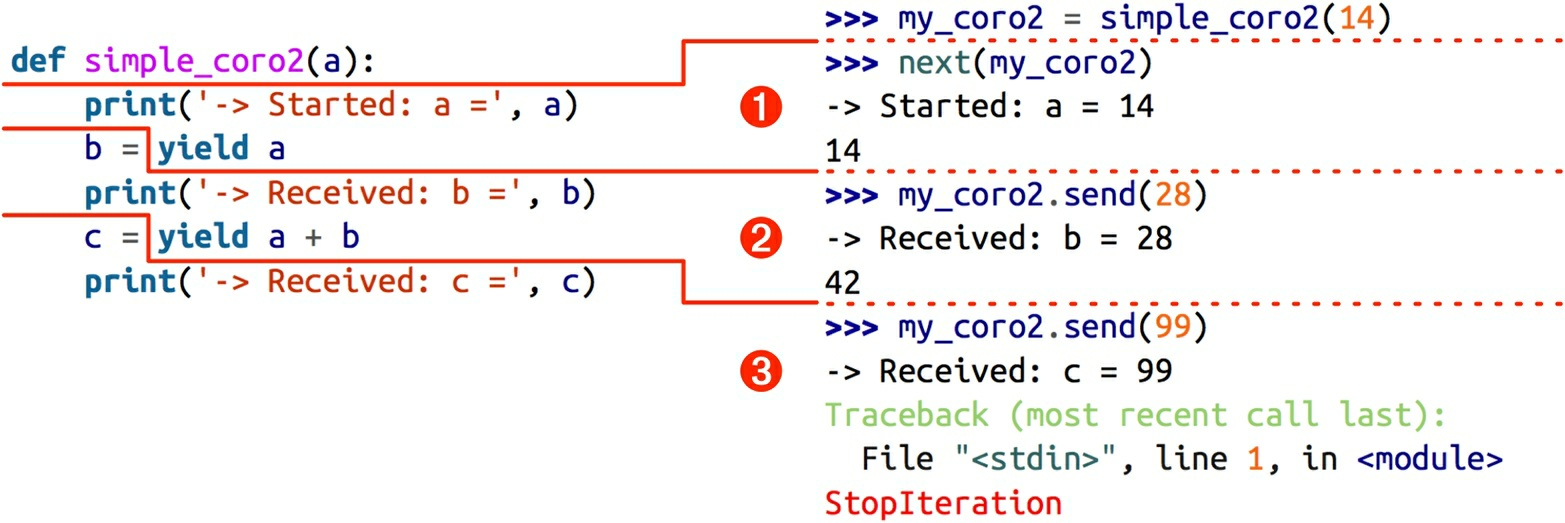

In [10]:
from IPython.display import Image
Image(filename='yield.png') 

## 使用协程计算移动平均值

下面我们展示如何用协程计算移动平均值：

In [11]:
def averager():
    total =0.0
    count = 0
    average = None
    while True:
        term = yield average
        total += term
        count += 1
        average = total / count

这个无限循环表明，只要调用方不断把值发给协程，它就会一直接收值，然后生成结果。晋档调用方在协程上调用 .close() 方法，或者没有协程的引用而被垃圾回收程序回收时，这个协程才会终止。

这里的 yield 用于暂停协程，把结果发给调用方；还用于接收调用方后面发给协程的值，恢复无线循环

使用协程的好处是 total 和 count 生成为局部变量就好，不用使用闭包

In [12]:
coro_avg = averager()
next(coro_avg)
coro_avg.send(10)

10.0

In [13]:
coro_avg.send(30)

20.0

In [14]:
coro_avg.send(5)

15.0

我们一定想知道如何停止这个协程，但是在此之前我们先讨论如何启动协程在使用协程之前必须要预激，这一步容易忘记，为了避免忘记，可以在协程上使用一个特殊的装饰器

## 预激协程的装饰器

如果不预激，那么协程没什么用。调用 my_cor.send(x) 之前，记住一定要调用 next(my_coro)。为了简化协程的用法，有时会使用一个预激装饰器，下面就是一个例子：

In [15]:
from functools import wraps

def coroutine(func):
    @wraps(func)
    def primer(*args, **kwargs): 
    # 把装饰器生成器函数替换成这里的 primer 函数
    # 调用 primer 函数时，返回预激后的生成器
        gen = func(*args, **kwargs) # 调用被装饰的函数，获取生成器对象
        next(gen) # 预激生成器
        return gen # 返回生成器
    return primer

In [16]:
@coroutine
def averager():
    total = 0.0
    count = 0
    average = None
    while True:
        term = yield average
        total += term
        count += 1
        average = total / count

In [17]:
coro_avg = averager() # 使用 coroutine 装饰的协程，可以立即开始发送值
coro_avg.send(40)

40.0

In [18]:
coro_avg.send(50)

45.0

In [19]:
coro_avg.send('spam') # 发送的不是数字，导致协程内部有异常抛出

TypeError: unsupported operand type(s) for +=: 'float' and 'str'

In [20]:
coro_avg.send(60) # 由于协程内部没有异常处理，协程会终止，试图重新激活协程，会抛出 StopIteration 异常

StopIteration: 

使用 yield from 语法调用协程也会自动预激（一会讲），因此会和上面的 @coroutine 装饰器不兼容。Python 3.4 标准库中的 asyncio.coroutine 装饰器（第 18 章）不会预激协程，因此能兼容 yield from 方法

## 终止协程和异常处理

上面的出错原因是 'spam' 不能加到 total 变量上。

上面例子暗示了一种终止协程的方式：发送某个哨符值，让协程退出，内置的 None 和 Ellipsis 等常量通常作为哨符值。 Ellipsis 的优点是，数据流中不太常有这个值。还有人用 StopIteration 类（类本身，而不是实例，也不抛出）作为哨符值，也就是说是这样使用的：`my_coro.send(StopIteration)`

从 Python 2.5 开始，客户可以在生成器对象上调用两个方法，显式的把异常发给协程，这两个方法是 throw 和 close

generator.throw(exc_type[, exc_value[, traceback]])

- 致使生成器在暂停的 yield 表达式抛出指定的异常。如果生成器处理了抛出的异常，代码会向前执行到下一个 yield 表达式，而产出的值会成为调用 generator.throw 方法得到的返回值，如果生成器没有处理抛出的异常，异常会向上冒泡，传到调用方的上下文中

generator.close() 

- 致使生成器暂停的 yield 表达式抛出的 GeneratorExit 异常。如果生成器没有处理这个异常，或者抛出了 StopIteration 异常（通常是指运行到结尾），调用方不会报错，如果收到了 GeneratorExit 异常，生成器一定不能产出值，否则解释器会抛出 RuntimeError 异常。生成器抛出的其他异常会向上冒泡，传给调用方

下面展示如何使用 close 和 throw 方法控制协程

In [21]:
class DemoException(Exception):
    '''为这次演示定义的异常类型'''
    
def demo_exc_handling():
    print('-> coroutine started')
    while True:
        try:
            x = yield
        except DemoException: # 特别处理 DemoException 异常
            print('*** DemoException handled. Continuing...')
        else:
            print('-> coroutine received: {!r}'.format(x))
    # 这一行永远不会执行，因为有未处理异常才会终止循环，而一旦出现未处理异常，协程就会终止
    raise RuntimeError('This line should never run') 

In [22]:
exc_coro = demo_exc_handling()
next(exc_coro)

-> coroutine started


In [23]:
exc_coro.send(11)

-> coroutine received: 11


In [24]:
exc_coro.send(22)

-> coroutine received: 22


In [25]:
exc_coro.close()

In [26]:
from inspect import getgeneratorstate
getgeneratorstate(exc_coro)

'GEN_CLOSED'

如果把 DemoException 异常传入 demo_exc_handling 协程，它会处理，然后继续运行，如下：

In [27]:
exc_coro = demo_exc_handling()
next(exc_coro)

-> coroutine started


In [28]:
exc_coro.send(11)

-> coroutine received: 11


In [29]:
exc_coro.throw(DemoException)

*** DemoException handled. Continuing...


In [30]:
getgeneratorstate(exc_coro)

'GEN_SUSPENDED'

但是，传入协程的异常没有处理，协程会停止，即状态变成 GEN_CLOSE:

In [31]:
exc_coro = demo_exc_handling()
next(exc_coro)

-> coroutine started


In [32]:
exc_coro.send(11)

-> coroutine received: 11


In [33]:
exc_coro.throw(ZeroDivisionError)

ZeroDivisionError: 

In [34]:
getgeneratorstate(exc_coro)

'GEN_CLOSED'

如果不管协程如何结束都想做那些清理工作，要把协程定义体中相关代码放入 try/finally 块中，如下：

In [35]:
class DemoException(Exception):
    '''为这次演示定义的异常类型'''
    
def demo_finally():
    print('-> coroutine started')
    try:
        while True:
            try:
                x = yield
            except DemoException: # 特别处理 DemoException 异常
                print('*** DemoException handled. Continuing...')
            else:
                print('-> coroutine received: {!r}'.format(x))
    finally:
        print('-> coroutine ending')

Python 3.3 引入 yield from 结构的主要原因之一与把异常传入嵌套的协程有关。另一个原因是让协程更方便的返回值

## 让协程返回值

下面的这个 averager 例子会返回结果，为了说明如何返回值，每次激活协程时不会产出移动平均值。这么做是为了强调某些协程不会产出值，而是在最后返回一个值（通常是累计值）

下面 average 返回一个 numedtuple，两个字段分别是项数（count）和平均值（average)

In [36]:
from collections import namedtuple

Result = namedtuple('Result', 'count average')

def averager():
    total = 0.0
    count = 0
    average = None
    while True:
        term = yield
        if term is None: # 为了返回值，协程必须正常停止
            break
        total += term
        count += 1
        average = total / count
    return Result(count, average) # 返回 namedtuple，在 Python 3.3 之前如果生成器返回值会报错

In [37]:
coro_avg = averager()
next(coro_avg)
coro_avg.send(10) # 这一版不返回值

In [38]:
coro_avg.send(30)
coro_avg.send(6.5)
# 发 None 会终止循环，导致协程结束，一如既往，生成器会抛出 StopIteration 异常，异常对象的 value 属性保存着返回的值
coro_avg.send(None) 

StopIteration: Result(count=3, average=15.5)

下面展示捕获 StopIteration 异常：

In [39]:
coro_avg = averager()
next(coro_avg)
coro_avg.send(10)
coro_avg.send(30)
coro_avg.send(6.5)
try:
    coro_avg.send(None)
except StopIteration as exc:
    result = exc.value
result

Result(count=3, average=15.5)

获取协程返回值虽然要绕个圈子，但是这是 PEP 380 定义的方式，如果我们意识到这一点就说得通了，yield from 结构会在内部自动捕获 StopIteration 异常。这种处理方式与 for 循环处理 StopIteration 异常的方式一样，循环机制使用户用易于理解的方式处理异常，对于 yield from 来说，解释器不仅会捕获 StopIteration 异常，而且还会把 value 属性的值变成 yield from 表达式的值。可惜，我们无法在控制台中使用交互的方式测试这种行为，因为在函数外部使用 yield from（以及 yield）会导致语法出错

## 使用 yield from

首先要知道 yield from 是全新的语言结构，它的作用要比 yield 多很多，因此人们认为继续使用那个关键字多少会引起误解。在其他语言中，类似的结构用 await 关键字，这个名称好多了，因为它传达了至关重要的一点：在生成器 gen 中使用 yield from subgen() 时，subgen 会获得控制权，把产出值传给 gen 的调用方，即调用方可以直接控制 subgen，于此同时，gen 会阻塞，等待 subgen 终止

14 章说过，yield from 可用于简化 for 循环中的 yield 表达式，例如：

In [40]:
def gen():
    for c in 'AB':
        yield c
    for i in range(1, 3):
        yield i
list(gen())

['A', 'B', 1, 2]

可以改写成：

In [41]:
def gen():
    yield from 'AB'
    yield from range(1, 3)
list(gen())

['A', 'B', 1, 2]

在 14 章首次提到 yield from 时举了一个例子，演示这个结构用法：

In [42]:
def chain(*iterables):
    for it in iterables:
        yield from it

s = 'ABC'
t = tuple(range(3))
list(chain(s, t))

['A', 'B', 'C', 0, 1, 2]

yield from x 表达式对 x 做的第一件事是就是，调用 iter(x), 从中获取迭代器。因此 x 可以是任何可迭代对象。

可是，如果 yield from 结构唯一的作用是替代产出值的嵌套 for 循环，这个结构很有可能不会添加到 Python 语言中。yield from 结构本质作用无法通过简单的可迭代对象说明，而且要发散思维，用嵌套的生成器。

yield from 主要功能是打开双向通道，把最外层的调用方与最内层的子生成器连接起来，这样二者可以直接发送可产出值，还可以直接传入异常，而不用在位于中间的协程中添加大量处理异常的样板代码，有了这个结构，协程可以通过以前不可能的方式委托职责

要想使用 yield from 结构，需要大量修改代码，为了说明需要改动的部分，下面是一些专门术语：

- 委派生成器：包含 yield from <iterable> 表达式的生成器函数

- 子生成器：从 yield from 表达式中 <iterable> 部分获取的生成器

- 调用方： 调用委派生成器的客户端代码，在不同语境中，我们会使用客户端代替调用方，以此与委派生成器（也是调用方，因为它调用了子生成器）区分开


委派生成器在 yield from 表达式处暂停，调用方可以直接把数据发给子生成器，自生成器再把产出的值发给调用方。自生成器返回之后，解释器会抛出 StopIteration 异常，并把返回值附加到异常对象上，此时委派生成器会恢复



In [46]:
from collections import namedtuple
from time import sleep

Result = namedtuple('Result', 'count average')

# 子生成器
def averager():
    total = 0.0
    count = 0
    average = None
    while True:
#         print('11111')
        term = yield # main 函数中的客户代码发送的各个值绑定到这里的 term 变量
        if term is None: # 很重要的停止条件，不这么做，yield from 调用此协程会永远阻塞
            break
        total += term
        count += 1
        average = total / count
    return Result(count, average) # 返回的 Result 会成为 grouper 函数中的 yield from 表达式的值

# 委派生成器
def grouper(results, key):
    while True:  # 每次迭代会新建一个 average 实例，每个实例都是作为协程使用的生成器对象
        # grouper 发送的每个值都会经由 yield from 处理，通过管道传给 averager 实例
        # grouper 会在 yield from 表达式暂停，等待 averager 实例处理完客户端发来的值
        # averager 运行结束后，返回的值绑定到 results[key] 上，while 循环会不断的创建 averager 实例，处理更多的值
        results[key] = yield from averager() 
      
    
# 客户端代码
def main(data):
    results = {}
    for key, values in data.items():
        group = grouper(results, key) # 调用 grouper 得到生成器对象，传给 grouper 的第一个参数用于收集结果，group 作为协程使用
        next(group) # 预激
        # sleep(60)
        for value in values:
            #把各个 value 传给 grouper。传入的值最终到达 averager 函数中的 term = yield 那一行: 
            # grouper 永远不知道传入的值是什么
            group.send(value) 
        #　把 None 传入grouper，导致当前的averager 实例终止，也让 grouper 继续运行，然后再创建一组 averager 实例，处理下一组值
        group.send(None) # 重要，没有这行 averager 不会终止，results[key] 不会被赋值就到了下一个 group
        
        #print(results)
    report(results)
        
# 输出报告
def report(results):
    for key, result in sorted(results.items()):
        group, unit = key.split(';')
        print('{:2} {:5} averaging {:.2f}{}'.format(
            result.count, group, result.average, unit))
        
data = {
    'girls;kg':
        [40.9, 38.5, 44.3, 42.2, 45.2, 41.7, 44.5, 38.0, 40.6, 44.5],
    'girls;m':
        [1.6, 1.51, 1.4, 1.3, 1.41, 1.39, 1.33, 1.46, 1.45, 1.43],
    'boys;kg':
        [39.0, 40.8, 43.2, 40.8, 43.1, 38.6, 41.4, 40.6, 36.3],
    'boys;m':
        [1.38, 1.5, 1.32, 1.25, 1.37, 1.48, 1.25, 1.49, 1.46],
}

main(data)

 9 boys  averaging 40.42kg
 9 boys  averaging 1.39m
10 girls averaging 42.04kg
10 girls averaging 1.43m


这个试验想表明的关键一点是,如果子生成器不终止,委派生成器会在 yield from 表达式处永远暂停。如果是这样,程序不会向前执行,因为 yield from(与 yield 一样)把控制权转交给客户代码（即，委派生成器的调用方）了，显然，可定有任务无法完成

上面例子展示了 yield from 的最简单用法，只有一个委派生成器和一个子生成器。因为委派生成器相当于管道，所以可以把任意数量个委派生成器连接在一起：一个委派生成器使用 yield from 调用一个子生成器，而那个子生成器本身也是委派生成器，使用 yield from 调用另一个子生成器，以此类推。最终，这个链条要以一个只使用 yield 表达式的简单生成器结束，不过，也能以任何可迭代对象结束。

任何 yield from 链条必须由客户驱动，最外层委派生成器调用 next(...) 函数或 .send(...) 方法。可以隐式调用，例如使用 for 循环

## yield from 的意义

把迭代器当做生成器使用，相当于把子生成器的定义体内联在 yield from 表达式中。此外，子生成器可以执行 return 语句，返回一个值，而返回的值会称为 yield from 表达式的值

- 子生成器产出的值都直接传给委派生成器的调用方（即客户端代码）
- 使用 send() 方法发送给委派生成器的值都直接传给子生成器。如果发送的值是 None，那么会调用子生成器的 `__next__()` 方法，如果不是 None，会调用 send() 方法，如果调用方法抛出 StopIteration 异常，那么委派生成器恢复运行。任何其他异常都会向上冒泡，传给委派生成器
- 生成器退出时，生成器（或子生成器）的 return expr 表达式会触发 StopIteration(expr) 异常抛出
- yield from 表达式的值是子生成器终止时传给 StopIteration 异常的第一个参数
- 传入委派生成器的异常，除了 GeneratorExit 之外都传给子生成器的 throw() 方法。如果调用 throw() 方法时抛出 StopIteration 异常，委派生成器恢复运行。StopIteration 之外的异常会向上冒泡，传给委派生成器
- 如果把 GeneratorExit 异常传给委派生成器，或者委派生成器上调用 close() 方法，那么在自生成撑起调用 close() 方法，如果它有的话，如果调用 close() 方法导致异常抛出，那么异常会向上冒泡，传给委派生成器，否则，委派生成器抛出 GeneratorExit 异常